In [29]:
# https://jessesw.com/XG-Boost/
# https://www.dataiku.com/learn/guide/code/python/advanced-xgboost-tuning.html Using Sparce Matrix
import xgboost as xgb
import pandas as pd
from sklearn.grid_search import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score


# train data
data = pd.read_csv('data/train.csv', header = 0)
data = data.fillna(-1)
print(data.info())
X = data.drop(['order_id','master_id', 'target', 'cancel_proba'], axis=1)
y = data['target']

folds = 5
kf = KFold(folds, shuffle = True, random_state = 42)

#for train_index, test_index in kf.split(X):
#    print("TRAIN:", train_index, "TEST:", test_index)
#    X_train, X_val = X.iloc[train_index], X.iloc[test_index]
#    y_train, y_val = y[train_index], y[test_index]


train_indeces, val_indeces = next(kf.split(y))

X_train, y_train = X.iloc[train_indeces], y[train_indeces]
X_val, y_val = X.iloc[val_indeces], y[val_indeces]

dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)
# del(data, X, y)

# test data
test_data = pd.read_csv('data/test.csv', header = 0)
X_test = test_data.drop(['order_id','master_id', 'target', 'cancel_proba'], axis=1)
y_test = test_data['target']
dtest = xgb.DMatrix(X_test, label=y_test)

#print(y_test)
#del(test_data, X_test, y_test)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20545 entries, 0 to 20544
Data columns (total 23 columns):
rooms              20545 non-null int64
order_type         20545 non-null int64
days_to_cln        20545 non-null int64
total_time         20545 non-null float64
commission         20545 non-null float64
target             20545 non-null int64
work_proba         20545 non-null float64
cancel_proba       20545 non-null float64
order_id           20545 non-null int64
master_id          20545 non-null int64
rooms_0_cnt        20545 non-null int64
rooms_1_cnt        20545 non-null int64
rooms_2_cnt        20545 non-null int64
rooms_3_cnt        20545 non-null int64
rooms_4_cnt        20545 non-null int64
rooms_0_shr        20545 non-null float64
rooms_1_shr        20545 non-null float64
rooms_2_shr        20545 non-null float64
rooms_3_shr        20545 non-null float64
rooms_4_shr        20545 non-null float64
lite_shr           20545 non-null float64
avg_total_time     20545 non-nu

# Grid Search

In [23]:
cv_params = {
    'max_depth': [3, 4, 5, 6, 7],
    'learning_rate': [0.01, 0.1, 0.3]
    #'min_child_weight': [1,3]
}
# ind_params = {'objective': 'binary:logistic', 'n_estimators': 100}
ind_params = {
    'learning_rate': 0.1,
    'n_estimators': 1000,
    'seed':0,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'objective': 'binary:logistic'}


optimized_GBM = GridSearchCV(xgb.XGBClassifier(**ind_params), cv_params, scoring = 'roc_auc', cv = 3, n_jobs = 1) 
# Optimize for accuracy since that is the metric used in the Adult Data Set notation

In [24]:
%%time
optimized_GBM.fit(X, y)

CPU times: user 12min 20s, sys: 1min 9s, total: 13min 30s
Wall time: 4min 42s


GridSearchCV(cv=3, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.8,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=1000, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=0.8),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'max_depth': [3, 4, 5, 6, 7], 'learning_rate': [0.01, 0.1, 0.3]},
       pre_dispatch='2*n_jobs', refit=True, scoring='roc_auc', verbose=0)

In [25]:
optimized_GBM.grid_scores_

[mean: 0.64214, std: 0.02080, params: {'max_depth': 3, 'learning_rate': 0.01},
 mean: 0.64097, std: 0.02016, params: {'max_depth': 4, 'learning_rate': 0.01},
 mean: 0.63887, std: 0.02054, params: {'max_depth': 5, 'learning_rate': 0.01},
 mean: 0.63588, std: 0.02066, params: {'max_depth': 6, 'learning_rate': 0.01},
 mean: 0.63239, std: 0.02152, params: {'max_depth': 7, 'learning_rate': 0.01},
 mean: 0.62454, std: 0.01919, params: {'max_depth': 3, 'learning_rate': 0.1},
 mean: 0.61527, std: 0.01807, params: {'max_depth': 4, 'learning_rate': 0.1},
 mean: 0.60275, std: 0.01491, params: {'max_depth': 5, 'learning_rate': 0.1},
 mean: 0.60484, std: 0.01429, params: {'max_depth': 6, 'learning_rate': 0.1},
 mean: 0.59732, std: 0.01333, params: {'max_depth': 7, 'learning_rate': 0.1},
 mean: 0.59827, std: 0.01456, params: {'max_depth': 3, 'learning_rate': 0.3},
 mean: 0.59412, std: 0.01350, params: {'max_depth': 4, 'learning_rate': 0.3},
 mean: 0.58760, std: 0.01362, params: {'max_depth': 5, 'lea

In [26]:
y_pred = optimized_GBM.predict(X_test)
print(roc_auc_score(y_test, y_pred))

0.608460392569


# Early Stopping

In [31]:
# specify parameters via map
param = {'max_depth':3, 'eta':0.1, 'silent':0, 'objective':'binary:logistic' }
param['eval_metric'] = 'auc'
evallist  = [(dtrain,'train'), (dval,'eval')]
num_round = 300

bst = xgb.train(param, dtrain, num_round, evallist, early_stopping_rounds=10)
# make prediction
preds = bst.predict(dtest)

print(roc_auc_score(y_test, preds))

[0]	train-auc:0.574547	eval-auc:0.55759
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 10 rounds.
[1]	train-auc:0.576938	eval-auc:0.560007
[2]	train-auc:0.591223	eval-auc:0.567242
[3]	train-auc:0.596315	eval-auc:0.568823
[4]	train-auc:0.598578	eval-auc:0.573906
[5]	train-auc:0.599703	eval-auc:0.575722
[6]	train-auc:0.60508	eval-auc:0.579852
[7]	train-auc:0.607194	eval-auc:0.578282
[8]	train-auc:0.611097	eval-auc:0.584818
[9]	train-auc:0.61399	eval-auc:0.586465
[10]	train-auc:0.616103	eval-auc:0.588437
[11]	train-auc:0.619196	eval-auc:0.59274
[12]	train-auc:0.620758	eval-auc:0.593385
[13]	train-auc:0.621276	eval-auc:0.595108
[14]	train-auc:0.623348	eval-auc:0.598124
[15]	train-auc:0.625302	eval-auc:0.5994
[16]	train-auc:0.626528	eval-auc:0.600266
[17]	train-auc:0.627746	eval-auc:0.601711
[18]	train-auc:0.6286	eval-auc:0.601681
[19]	train-auc:0.629073	eval-auc:0.601437
[20]	train-auc:0.629495	eval-auc:0.60

[191]	train-auc:0.684759	eval-auc:0.624602
[192]	train-auc:0.684805	eval-auc:0.624534
[193]	train-auc:0.68507	eval-auc:0.62463
[194]	train-auc:0.685465	eval-auc:0.62462
[195]	train-auc:0.6859	eval-auc:0.624691
[196]	train-auc:0.685917	eval-auc:0.624695
[197]	train-auc:0.686079	eval-auc:0.624854
[198]	train-auc:0.686089	eval-auc:0.624705
[199]	train-auc:0.686459	eval-auc:0.624939
[200]	train-auc:0.686639	eval-auc:0.624877
[201]	train-auc:0.686759	eval-auc:0.624808
[202]	train-auc:0.686786	eval-auc:0.624806
[203]	train-auc:0.686905	eval-auc:0.624798
[204]	train-auc:0.686908	eval-auc:0.624789
[205]	train-auc:0.686912	eval-auc:0.624784
[206]	train-auc:0.687223	eval-auc:0.625019
[207]	train-auc:0.687742	eval-auc:0.625014
[208]	train-auc:0.687917	eval-auc:0.625273
[209]	train-auc:0.687927	eval-auc:0.625268
[210]	train-auc:0.688043	eval-auc:0.625329
[211]	train-auc:0.688156	eval-auc:0.625349
[212]	train-auc:0.688333	eval-auc:0.625473
[213]	train-auc:0.688368	eval-auc:0.625467
[214]	train-auc:

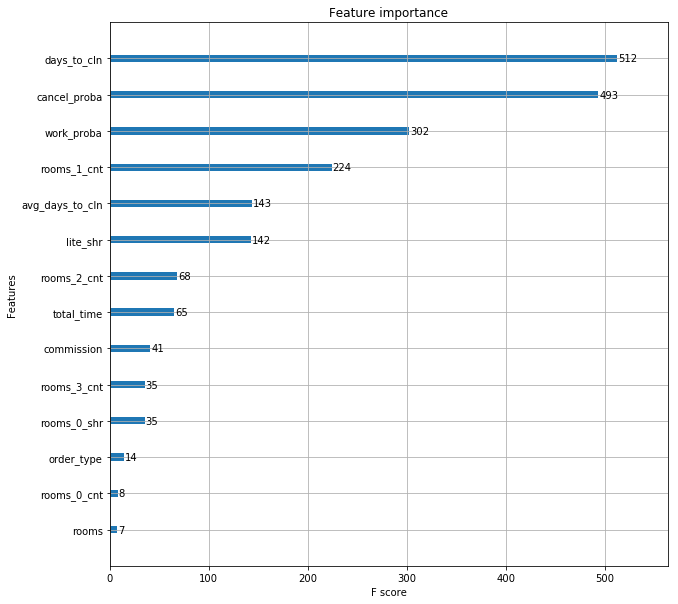

In [28]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

width = 20
height = 20
#plt.figure(figsize=(width, height))
fig, ax = plt.subplots(figsize=(10, 10))
xgb.plot_importance(bst, ax=ax)
